In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import random
from aif360.algorithms.inprocessing.gerryfair_classifier import *
from aif360.algorithms.inprocessing.gerryfair.clean import *
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import *
from aif360.algorithms.inprocessing.gerryfair.auditor import *
from sklearn import svm
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from IPython.display import Image
import pickle
import matplotlib.pyplot as plt

# load data set
data_set = load_preproc_data_adult(sub_samp=1000, balance=True)
max_iterations = 500

**instantiate, fit, and predict** 


We first demonstrate how to instantiate a `Model`, `train` it with respect to rich subgroup fairness, and `predict` the label of a new example. We remark that when we set the `print_flag = True` at each iteration of the algorithm we print the error, fairness violation, and violated group size of most recent model. The error is the classification error of the classifier. At each round the Learner tries to find a classifier that minimizes the classification error plus a weighted sum of the fairness disparities on all the groups that the Auditor has found up until that point. By contrast the Auditor tries to find the group at each round with the greatest rich subgroup disparity with respect to the Learner's model. We define `violated group size` as the size (as a fraction of the dataset size) of this group, and the `fairness violation` as the `violated group size` times the difference in the statistical rate (FP or FN rate) on the group vs. the whole population. 

In the example below we set `max_iterations=500` which is an order of magnitude less than the time to convergence observed in [the rich subgroup fairness empirical paper](https://arxiv.org/abs/1808.08166), but advise that this can be highly dataset dependent. Our target $\gamma$-disparity is $\gamma = .005$, our statistical rate is false positive rate or `FP`, and our cost-sensitive classification oracle is linear regression (more on that below). We observe that the unconstrained (with no fairness constraint) classifier has error $.235$ and $\gamma$-disparity $.044$. After $500$ iterations we obtain a classifier that $\gamma$-fair, and has error $.43$. 


In [2]:
C = 100
print_flag = True
gamma = .005


fair_model = Model(C=C, printflag=print_flag, gamma=gamma, fairness_def='FP',
             max_iters=max_iterations, heatmapflag=False)

# fit method
communities_all_errors, communities_violations = fair_model.fit(data_set,
                                                 early_termination=True, return_values=True)

# predict method. If threshold in (0, 1) produces binary predictions

dataset_yhat = fair_model.predict(data_set, threshold=False)




iteration: 1, error: 0.263, fairness violation: 0.043504000000000015, violated group size: 0.276
iteration: 2, error: 0.3815, fairness violation: 0.021752000000000007, violated group size: 0.276
iteration: 3, error: 0.421, fairness violation: 0.014501333333333335, violated group size: 0.276
iteration: 4, error: 0.44075, fairness violation: 0.010876000000000004, violated group size: 0.276
iteration: 5, error: 0.45260000000000006, fairness violation: 0.008700800000000003, violated group size: 0.276
iteration: 6, error: 0.4605, fairness violation: 0.007250666666666669, violated group size: 0.276
iteration: 7, error: 0.46614285714285725, fairness violation: 0.006214857142857146, violated group size: 0.276
iteration: 8, error: 0.470375, fairness violation: 0.005438000000000002, violated group size: 0.224
iteration: 9, error: 0.47366666666666674, fairness violation: 0.00483377777777778, violated group size: 0.224
iteration: 10, error: 0.47630000000000006, fairness violation: 0.00435040000000

iteration: 76, error: 0.46603947368421045, fairness violation: 0.002930315789473684, violated group size: 0.224
iteration: 77, error: 0.4651558441558442, fairness violation: 0.002991168831168831, violated group size: 0.224
iteration: 78, error: 0.46429487179487183, fairness violation: 0.003050461538461539, violated group size: 0.276
iteration: 79, error: 0.46345569620253174, fairness violation: 0.003108253164556961, violated group size: 0.224
iteration: 80, error: 0.4626375000000001, fairness violation: 0.0031646000000000005, violated group size: 0.276
iteration: 81, error: 0.4618395061728396, fairness violation: 0.0032195555555555562, violated group size: 0.276
iteration: 82, error: 0.4610609756097561, fairness violation: 0.0032731707317073186, violated group size: 0.276
iteration: 83, error: 0.4603012048192771, fairness violation: 0.003325493975903615, violated group size: 0.224
iteration: 84, error: 0.45955952380952375, fairness violation: 0.0033765714285714284, violated group size:

iteration: 150, error: 0.4217133333333334, fairness violation: 0.004876053333333339, violated group size: 0.319
iteration: 151, error: 0.42117218543046353, fairness violation: 0.004910887417218546, violated group size: 0.181
iteration: 152, error: 0.42065789473684206, fairness violation: 0.004940500000000006, violated group size: 0.319
iteration: 153, error: 0.42015032679738556, fairness violation: 0.004969725490196081, violated group size: 0.181
iteration: 154, error: 0.4196298701298701, fairness violation: 0.005003272727272732, violated group size: 0.319
iteration: 155, error: 0.41916129032258065, fairness violation: 0.005024709677419358, violated group size: 0.181
iteration: 156, error: 0.418698717948718, fairness violation: 0.0050458717948718, violated group size: 0.319
iteration: 157, error: 0.4182420382165604, fairness violation: 0.005066764331210194, violated group size: 0.181
iteration: 158, error: 0.41779113924050626, fairness violation: 0.005087392405063296, violated group si

iteration: 224, error: 0.4266116071428571, fairness violation: 0.004554839285714286, violated group size: 0.181
iteration: 225, error: 0.4267599999999999, fairness violation: 0.004545857777777778, violated group size: 0.181
iteration: 226, error: 0.42690707964601776, fairness violation: 0.004536955752212393, violated group size: 0.319
iteration: 227, error: 0.4270528634361234, fairness violation: 0.004528132158590309, violated group size: 0.181
iteration: 228, error: 0.42719736842105266, fairness violation: 0.004519385964912282, violated group size: 0.319
iteration: 229, error: 0.4273406113537118, fairness violation: 0.004510716157205241, violated group size: 0.181
iteration: 230, error: 0.4274826086956523, fairness violation: 0.004502121739130436, violated group size: 0.181
iteration: 231, error: 0.4276233766233766, fairness violation: 0.004493601731601732, violated group size: 0.181
iteration: 232, error: 0.4277629310344829, fairness violation: 0.0044851551724137935, violated group s

iteration: 297, error: 0.42730303030303024, fairness violation: 0.005004525252525254, violated group size: 0.224
iteration: 298, error: 0.4272046979865772, fairness violation: 0.0050132885906040295, violated group size: 0.224
iteration: 299, error: 0.42710702341137124, fairness violation: 0.00502199331103679, violated group size: 0.224
iteration: 300, error: 0.42701, fairness violation: 0.005030640000000002, violated group size: 0.224
iteration: 301, error: 0.42691362126245846, fairness violation: 0.005039229235880401, violated group size: 0.276
iteration: 302, error: 0.427023178807947, fairness violation: 0.0050329271523178835, violated group size: 0.276
iteration: 303, error: 0.42713201320132016, fairness violation: 0.005026666666666669, violated group size: 0.276
iteration: 304, error: 0.4272401315789474, fairness violation: 0.005020447368421054, violated group size: 0.224
iteration: 305, error: 0.42734754098360656, fairness violation: 0.005014268852459018, violated group size: 0.22

iteration: 370, error: 0.42939729729729736, fairness violation: 0.004950681081081083, violated group size: 0.224
iteration: 371, error: 0.4293126684636118, fairness violation: 0.004957865229110517, violated group size: 0.276
iteration: 372, error: 0.4292284946236559, fairness violation: 0.0049650107526881745, violated group size: 0.276
iteration: 373, error: 0.4291447721179624, fairness violation: 0.004972117962466489, violated group size: 0.224
iteration: 374, error: 0.4290614973262032, fairness violation: 0.004979187165775403, violated group size: 0.276
iteration: 375, error: 0.4289786666666667, fairness violation: 0.004986218666666669, violated group size: 0.224
iteration: 376, error: 0.42889627659574464, fairness violation: 0.004993212765957448, violated group size: 0.224
iteration: 377, error: 0.428814323607427, fairness violation: 0.0050001697612732125, violated group size: 0.276
iteration: 378, error: 0.42873280423280413, fairness violation: 0.005007089947089953, violated group 

iteration: 443, error: 0.4323408577878103, fairness violation: 0.0048033408577878136, violated group size: 0.276
iteration: 444, error: 0.4324031531531532, fairness violation: 0.004799585585585588, violated group size: 0.224
iteration: 445, error: 0.4324651685393258, fairness violation: 0.004795847191011239, violated group size: 0.224
iteration: 446, error: 0.4323878923766816, fairness violation: 0.004802170403587447, violated group size: 0.276
iteration: 447, error: 0.43244966442953003, fairness violation: 0.004798442953020136, violated group size: 0.224
iteration: 448, error: 0.4325111607142858, fairness violation: 0.004794732142857145, violated group size: 0.224
iteration: 449, error: 0.43257238307349666, fairness violation: 0.0047910378619153695, violated group size: 0.276
iteration: 450, error: 0.43249555555555547, fairness violation: 0.004797315555555556, violated group size: 0.224
iteration: 451, error: 0.4325565410199557, fairness violation: 0.004793631929046566, violated group

**3-d heatmaps**

We now show to generate a 3d-heatmap of unfairness using the `generate_heatmap` method. The $X-Y$ axes in the plot represent the coefficients of the linear threshold function that defines a protected subgroup with respect to the first two sensitive attributes. Which $2$ attributes are considered sensitive can be overwritten with the `col_index` argument. The $Z$-axes is the $\gamma$-disparity (FP) of the corresponding subgroup defined by the linear threshold function. This is important because it allows us to (1) visualize convergence as the heatmap flattens and (2) brute force check the fairness in low-dimensions without relying on a heuristic auditor. See the [the rich subgroup fairness empirical paper](https://arxiv.org/abs/1808.08166) for a discussion of these plots. Note that in the below plot no group has a $\gamma$-disparity of greater than $.005$, which we would expect since the set of linear threshold functions on two attributes is a subset of the set of linear threshold functions on all protected attributes, and the final model is $\gamma$-fair. 

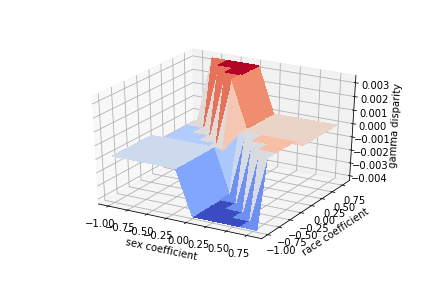

In [3]:

# output heatmap (brute force)
# replace None with the relative path if you want to save the plot
fair_model.heatmapflag = True
fair_model.heatmap_path  = 'heatmap'
fair_model.generate_heatmap(data_set, dataset_yhat.labels)
Image(filename='{}.png'.format(fair_model.heatmap_path)) 





**black-box auditing**

We now show to audit any black box classifier with respect to rich subgroup fairness under either FP or FN rate. Note the below auditing procedure would work for any set of (soft) predictions $\hat{y}$, and need make no assumptions about the structure of the predictor. We note that as expected the disparity of the group found is the same as the disparity printed out in the last iteration of the `fit` method.
   

In [4]:

# instantiate auditor
auditor = Auditor(data_set, 'FP')

y = array_to_tuple(data_set.labels)
predictions = array_to_tuple(dataset_yhat.labels)

# returns mean(predictions | y = 0) if 'FP' 1-mean(predictions | y = 1) if FN
metric_baseline = auditor.get_baseline(y, predictions)

# return the group with the largest disparity
group = auditor.get_group(dataset_yhat.labels, metric_baseline)

print('gamma disparity: {}'.format(group.weighted_disparity))






gamma disparity: 0.004876585170340687


**pareto curves**

The `FairFictPlay` algorithm implemented in the `fit` method converges given access to perfect oracles for solving cost-sensitive classification (CSC) problems. A cost-sensitive classification problem over a hypothesis class $\mathcal{H}$ is $$\min_{h}\sum_{i = 1}^{n}(1-h(x_i))c_0 + h(x_i)c_1$$
By default in this package, and in the companion [empirical](https://arxiv.org/abs/1808.08166) and [theory](https://arxiv.org/pdf/1711.05144.pdf) papers, the hypothesis class of the learner and the of the subgroups are hyperplanes. The corresponding heuristic oracle for solving the CSC problem first forms two regression problems $(x_i, c_0)$ and $(x_i, c_1)$. Then in the case of hyperplanes, trains two regressions $r_i: \mathcal{X} \to R$ which predict the costs of classifying a given point $x$ $0,1$ respectively. Finally the binary classifier output by the oracle is defined as $\hat{r}(x) = \arg\min_{j \in \{0,1\}}r_j(x)$. But of course if we are interesting in different hypothesis classes for the learner, we simply need different regressors. In this package in addition to linear regression, we've added support for regression trees, kernelized ridge regression, and support vector regression. Below we trace out Pareto curves of $\gamma$-disparity vs. error for each of these different heuristic oracles. 

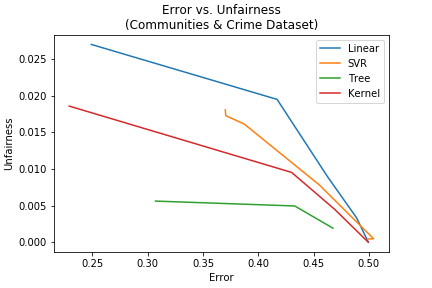

In [5]:
pareto_iters = 500
def multiple_classifiers_pareto(dataset, gamma_list=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], save_results=False, iters=pareto_iters):

    ln_predictor = linear_model.LinearRegression()
    svm_predictor = svm.LinearSVR()
    tree_predictor = tree.DecisionTreeRegressor(max_depth=3)
    kernel_predictor = KernelRidge(alpha=1.0, gamma=1.0, kernel='rbf')
    predictor_dict = {'Linear': {'predictor': ln_predictor, 'iters': iters},
                      'SVR': {'predictor': svm_predictor, 'iters': iters},
                      'Tree': {'predictor': tree_predictor, 'iters': iters},
                      'Kernel': {'predictor': kernel_predictor, 'iters': iters}}

    results_dict = {}

    for pred in predictor_dict:
        print('Curr Predictor: {}'.format(pred))
        predictor = predictor_dict[pred]['predictor']
        max_iters = predictor_dict[pred]['iters']
        fair_clf = Model(C=100, printflag=True, gamma=1, predictor=predictor, max_iters=max_iters)
        fair_clf.printflag = False
        fair_clf.set_options(max_iters=max_iters)
        errors, fp_violations, fn_violations = fair_clf.pareto(dataset, gamma_list)
        results_dict[pred] = {'errors': errors, 'fp_violations': fp_violations, 'fn_violations': fn_violations}
        plt.plot(errors, fp_violations, label=pred)

    if save_results:
        pickle.dump(results_dict, open('results_dict_' + str(gamma_list) + '_gammas' + str(gamma_list) + '.pkl', 'wb'))

    plt.xlabel('Error')
    plt.ylabel('Unfairness')
    plt.legend()
    plt.title('Error vs. Unfairness\n(Communities & Crime Dataset)')
    plt.savefig('gerryfair_pareto.png')
    plt.close()
multiple_classifiers_pareto(data_set)
Image(filename='gerryfair_pareto.png') 

A natural question one might ask is, suppose we fix a statistical fairness definition for rich subgroup fairness like equality of false positive rates, `FP`. Does learning a classifier that is fair with respect to `FP` increase or decrease fairness with respect to false negative rates `FN`? One could see this relationship going in either direction - and indeed we submit that it is dataset dependent. In some cases, if enforcing `FP` fairness pushes the classifier towards the constant classifier, then it will also satisify `FN` rate fairness, since the constant classifier is perfectly fair (this appears to be the case below). However, if the hypothesis class is sufficiently rich, then one would expect that ceteris paribus since we are optimizing for error in addition to `FP` rate fairness, the algorithm would increase `FN` rate unfairness in order to decrease error. Below we trace the FN vs. FP rate tradeoff across a range of input $\gamma$, where the classifier is optimized only for `FP` rate fairness. 

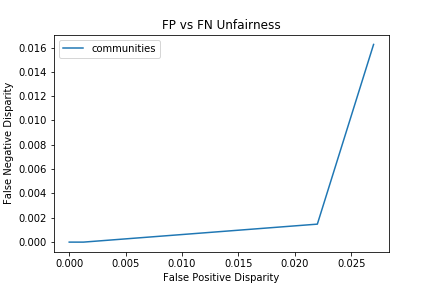

In [4]:
def fp_vs_fn(dataset, gamma_list, iters):
    fp_auditor = Auditor(dataset, 'FP')
    fn_auditor = Auditor(dataset, 'FN')
    fp_violations = []
    fn_violations = []
    for g in gamma_list:
        print('gamma: {} '.format(g), end =" ")
        fair_model = Model(C=100, printflag=False, gamma=g, max_iters=iters)
        fair_model.set_options(gamma=g)
        fair_model.fit(dataset)
        predictions = (fair_model.predict(dataset)).labels
        _, fp_diff = fp_auditor.audit(predictions)
        _, fn_diff = fn_auditor.audit(predictions)
        fp_violations.append(fp_diff)
        fn_violations.append(fn_diff)

    plt.plot(fp_violations, fn_violations, label='communities')
    plt.xlabel('False Positive Disparity')
    plt.ylabel('False Negative Disparity')
    plt.legend()
    plt.title('FP vs FN Unfairness')
    plt.savefig('gerryfair_fp_fn.png')
    plt.close()

gamma_list = [0.001, 0.002, 0.003, 0.004, 0.005, 0.0075, 0.01, 0.02, 0.03, 0.05]
fp_vs_fn(data_set, gamma_list, pareto_iters)
Image(filename='gerryfair_fp_fn.png')